## 目的
- 予稿の散布図はx,yに意味を持たない単純なPCAによる次元圧縮の散布図だったので、将棋エンジンの評価値と、ハッシュ値の差を撮った散布図を見てみる

## モジュールのインポート

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## データフレームの読み込み

In [3]:
df_f1 = pd.read_csv("../data/10321_pose_data_frameAbemaTV_Tournament_Final1.csv")
df_f2 = pd.read_csv("../data/7672_pose_data_frameAbemaTV_Tournament_Final2.csv")
df_f3 = pd.read_csv("../data/11296_pose_data_frameAbemaTV_Tournament_Final3.csv")

今回の散布図には時系列を加味する必要がないので直接データを結合する

In [56]:
# 散布図に必要なデータのみを抽出する
df = pd.concat([df_f1, df_f2, df_f3])

In [57]:
df_xy = df[["skelton_hash", "score"]]

In [58]:
## scoreが極端(詰み状況にある値を一旦削除)
df_xy = df_xy[df_xy["score"] < 9999]

In [60]:
df_xy.shape

(25917, 2)

In [61]:
df.head()

,skelton_hash,hand_number,score,score_label
0,26,0,0,0
1,26,0,0,0
2,26,0,0,0
3,28,0,0,0
4,26,0,0,0


## 事前に最適クラスタにクラスタリングしてみる

In [70]:
# シルエット分析による最適クラスタ数の決定
def select_n_cluster(X):
    n_clusters = 2
    silhouette_max = 0
    early_thresh = 4
    max_cluster = 100
 
    sse = []
    with tqdm(total=max_cluster) as pbar:
        while n_clusters < max_cluster:
            clusterer = KMeans(init='k-means++', n_clusters=n_clusters, random_state=0)
            cluster_labels = clusterer.fit_predict(X)
            kmeans = clusterer.fit(X)

            # SSE（クラスター内誤差の平方和）
            sse.append(kmeans.inertia_) 

            # シルエット値（-1～1）の平均
            silhouette_avg = silhouette_score(X, cluster_labels)

            print('For n_clusters =', n_clusters,
                  'The average silhouette_score is :', silhouette_avg)

            if silhouette_max < silhouette_avg:
                silhouette_max = silhouette_avg
                silhouette_max_id = n_clusters
            else:
                if (n_clusters - silhouette_max_id) > early_thresh:
                    break
                    
            n_clusters += 1
            pbar.update(1)
                    
        
    # エルボー図のプロット
    plt.plot([_ for _ in range(2, n_clusters+1)], sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()
    
    return silhouette_max_id

For n_clusters = 2 The average silhouette_score is : 0.5670557265518846
For n_clusters = 3 The average silhouette_score is : 0.6301941454934128
For n_clusters = 4 The average silhouette_score is : 0.5369985614503869
For n_clusters = 5 The average silhouette_score is : 0.5878652074419701
For n_clusters = 6 The average silhouette_score is : 0.5641714423880738
For n_clusters = 7 The average silhouette_score is : 0.5944779270906144
For n_clusters = 8 The average silhouette_score is : 0.5614557265419394



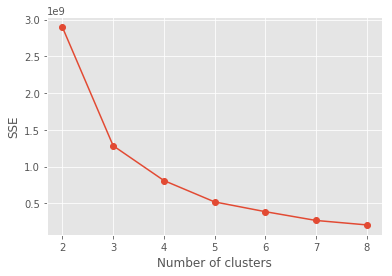

In [73]:
silhouette_max_id = select_n_cluster(df_xy)

## KMeansでクラスタリングして散布図出力

In [80]:
cls = KMeans(n_clusters=silhouette_max_id, random_state=98).fit(df_xy)

In [83]:
df_xy["cluster_id"] = cls.labels_

In [85]:
df_xy["cluster_id"].value_counts()

1    18103
0     6389
2     1425
Name: cluster_id, dtype: int64

In [86]:
df_xy.head()

,skelton_hash,score,cluster_id
0,26,0,1
1,26,0,1
2,26,0,1
3,28,0,1
4,26,0,1


In [90]:
df_prep = df[df.score < 9999]

In [103]:
df_prep.cluster_id = cls.labels_

/home/nvidia/.pyenv/versions/3.5.2/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


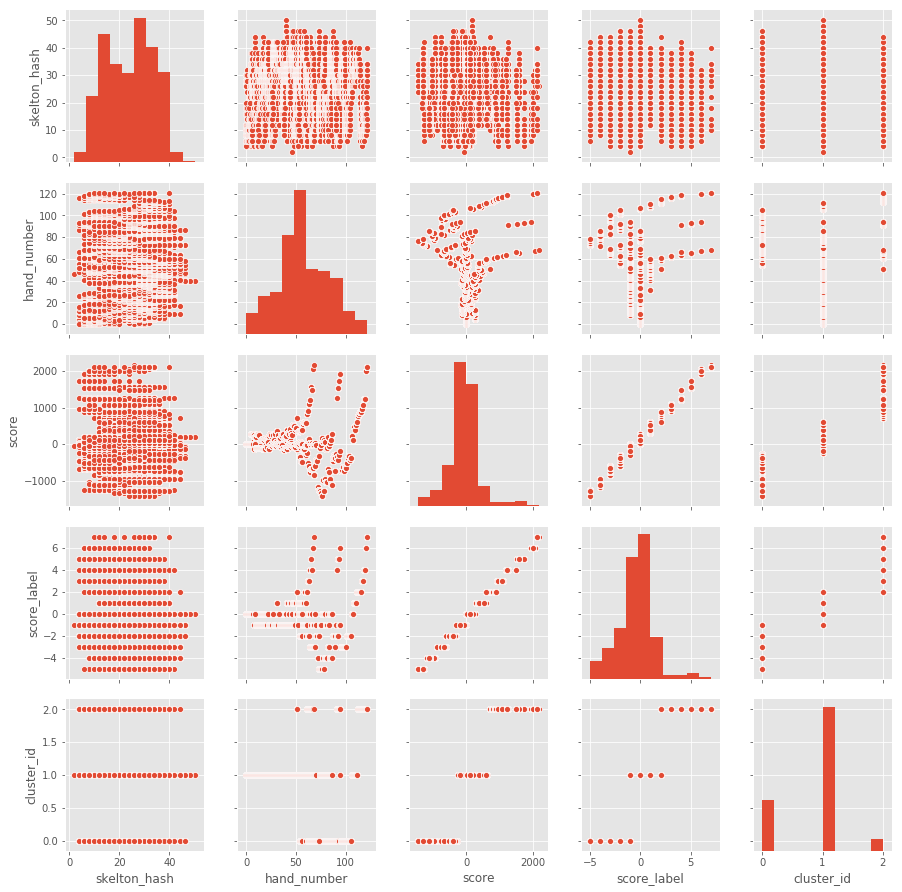

In [114]:
sns.pairplot(df_prep)

Text(0,0.5,'apery score')

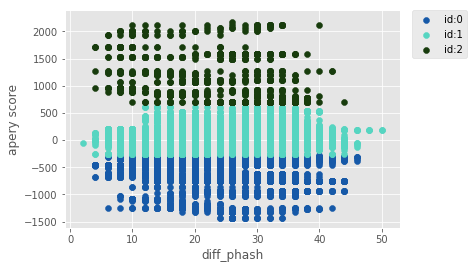

In [122]:
fig, ax = plt.subplots()
#colors = cm.Accent.colors
colors = np.random.rand(silhouette_max_id, 3)
for i in range(silhouette_max_id):
    target = df_prep[df_prep['cluster_id'] == i]
    ax.scatter(x=target.skelton_hash, y=target.score, c=colors[i])
    ax.legend(["id:{}".format(_) for _ in range(silhouette_max_id)], bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
ax.set_xlabel("diff_phash")
ax.set_ylabel("apery score")

Text(0,0.5,'apery score')

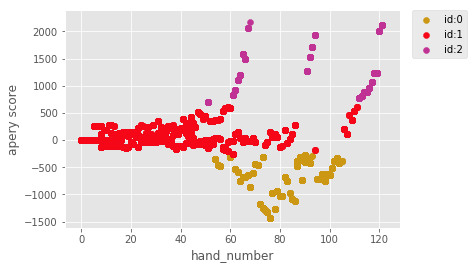

In [108]:
fig, ax = plt.subplots()
#colors = cm.Accent.colors
colors = np.random.rand(silhouette_max_id, 3)
for i in range(silhouette_max_id):
    target = df_prep[df_prep['cluster_id'] == i]
    ax.scatter(x=target.hand_number, y=target.score, c=colors[i])
    ax.legend(["id:{}".format(_) for _ in range(silhouette_max_id)], bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
ax.set_xlabel("hand_number")
ax.set_ylabel("apery score")

In [110]:
df_prep[df_prep['cluster_id'] == 2]

,skelton_hash,hand_number,score,score_label,cluster_id
10015,22,91,1267,4,2
10016,28,91,1267,4,2
10017,28,91,1267,4,2
10018,28,91,1267,4,2
10019,32,91,1267,4,2
10020,34,91,1267,4,2
10021,34,91,1267,4,2
10022,32,91,1267,4,2
10023,38,91,1267,4,2
10024,30,91,1267,4,2
